<h1>Installation and Setup</h1>
This is where all installations of third party libraries to require us the dependencies we need.



In [ ]:
! pip install --quiet transformers[torch] datasets seqeval pytorch-lightning torchmetrics==0.6.2
! pip install --quiet ipymarkup

     |████████████████████████████████| 4.4 MB 4.4 MB/s 
     |████████████████████████████████| 362 kB 37.6 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 585 kB 33.3 MB/s 
     |████████████████████████████████| 332 kB 38.3 MB/s 
     |████████████████████████████████| 212 kB 39.6 MB/s 
     |████████████████████████████████| 86 kB 4.6 MB/s 
     |████████████████████████████████| 140 kB 6.9 MB/s 
     |████████████████████████████████| 1.1 MB 38.1 MB/s 
     |████████████████████████████████| 596 kB 37.0 MB/s 
     |████████████████████████████████| 127 kB 37.0 MB/s 
     |████████████████████████████████| 144 kB 28.9 MB/s 
     |████████████████████████████████| 94 kB 1.9 MB/s 
     |████████████████████████████████| 271 kB 41.4 MB/s 
     |████████████████████████████████| 6.6 MB 34.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of

<h1> Imports</h1>
The following tools are what we need to use in order to check the nature of the data under the CoNLL Dataset we downloaded above.

<h4>Process</h4>
WE define the process based on the features and goals we would like to extract from the Data. The followin visualizations are our goal:

*   Identifying the sentence length based on the segmented text
*   Identifying the Skewness of each token that are under PHI terms mentioned before and
*   Identifying how the grammatical structure affects the labeled PHI term meaning in a sentence, contextual and token level.



In [ ]:
import torch
import transformers
import torchmetrics
import pytorch_lightning

print(f"torch: {torch.__version__}")
print(f"pytorch_lightning: {pytorch_lightning.__version__}")
print(transformers.__version__)
print(transformers.__spec__)
print(torchmetrics.__version__)

torch: 1.11.0+cu113
pytorch_lightning: 1.6.4
4.20.0
ModuleSpec(name='transformers', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f8e682fd5d0>, origin='/usr/local/lib/python3.7/dist-packages/transformers/__init__.py', submodule_search_locations=['/usr/local/lib/python3.7/dist-packages/transformers'])
0.6.2


In [ ]:
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", context="talk")
plt.style.use('default')
%matplotlib inline

In [ ]:
import os
import re
import gc
import sys
import random
import datetime
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict, namedtuple, Counter

from typing import (List, Dict, Any, Tuple, Optional, Union)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

<h2>Mounting Drive In Collab<h2>

We are preparing the sets we are going to use in order for us to perform EDA. Since I am experimenting in collab, this is a necessary step to extract and load the files.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',  force_remount=True)
    BASE_DIR = Path("/content/drive/MyDrive/NER/")
    DATA_DIR = BASE_DIR / "data"
    OUTPUT_DIR = BASE_DIR / "outputs"
    MODEL_CHKP_DIR = BASE_DIR / "models"

Mounted at /content/drive


In [ ]:
DATA_DIR

PosixPath('/content/drive/MyDrive/NER/data')

## Dataset Summary
The shared task of **CoNLL-2003** concerns language-independent named entity recognition. 

There are 4 types of named entities: 
* **persons**, 
* **locations**, 
* **organizations**, 
* **names of miscellaneous entities** that do not belong to the previous three groups.

The CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been put on a separate line and there is an empty line after each sentence. 

#### Columns:
1. **Token** - a single word,
2. **PoS** - a part-of-speech,
3. **SyncTag** - a syntactic chunk tag,
4. **NERTag** - the named entity tag

#### Other notes:
* Dataset uses **IOB1 tagging scheme**, where the `I- prefix` before a tag indicates that the tag is inside a chunk. An `O tag` indicates that a token belongs to no chunk. The `B- prefix` before a tag indicates that the tag is the beginning of a chunk that immediately follows another chunk without O tags between them. It is used only in that case: when a chunk comes after an O tag, the first token of the chunk takes the I- prefix. 
* `-DOCSTART-` - is a special line that acts as a boundary between two different documents.



In [ ]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa -P /content/data
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train -P /content/data

!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testb -P /content/data

--2022-06-17 09:47:58--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827012 (808K) [text/plain]
Saving to: ‘/content/data/eng.testa’

eng.testa           100%[===================>] 807.63K  --.-KB/s    in 0.06s   

2022-06-17 09:47:59 (13.7 MB/s) - ‘/content/data/eng.testa’ saved [827012/827012]

--2022-06-17 09:47:59--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3

In [ ]:
if DATA_DIR.exists():
    all_files = list(DATA_DIR.glob("*.*"))
    print(f"In Dataset dir found {len(all_files)} files:")
    for fn in all_files:
        print(f"\t{fn.name}")

train_fn = DATA_DIR / "eng.train"
val_fn = DATA_DIR / "eng.testa"

In Dataset dir found 3 files:
	eng.train
	eng.testa
	eng.testb


In [ ]:
class TextData:
    """ Representation of single sentence/text and it's attributes. """

    def __init__(self, tokens: List[str], 
                 ner_tags: List[str],
                 pos_tags: List[str] = None, 
                 sync_tags: List[str] = None) -> None:
        self.tokens = tokens
        self.ner_tags = ner_tags
        self.pos_tags = pos_tags
        self.sync_tags = sync_tags
        self.spans = None
    
    def __str__(self) -> str:
        s = f"Tokens: {self.tokens},\n"
        s += f"NER tags: {self.ner_tags},\n"
        s += f"Sync tags: {self.sync_tags},\n"
        s += f"POS tags: {self.pos_tags}."
        return s
    
    def set_spans(self, spans: List[List[int]]):
        """
        Initialize spans bondaries in the tokens sequence.
        Spans are `inclusive`.
        e.t. [start_i, end_i], not (start_i, end_i) !
        """
        self.spans = spans

In [ ]:
def split_tag(span_tag: str):
    """
    Split span tag into IOBES prefix and chunk_type
    e.g. 
    B-PER -> (B, PER)
    O -> (O, None)
    """
    if span_tag == 'O':
        return ('O', None)
    return span_tag.split('-', maxsplit=1)

def _is_doc_start(line: str) -> bool:
    if line.strip().startswith("-DOCSTART-"):
        return True
    return False

def _is_divider(line: str) -> bool:
    empty_line = line.strip() == ''
    if empty_line:
        return True
    return False

def read_conllu_data(data_fn: str):
    dataset = []

    with open(str(data_fn), 'rt') as f:
        for is_divider, lines in itertools.groupby(f, _is_divider):
            lines = list(lines)
            if is_divider or not len(lines[0]):
                continue
            if _is_doc_start(lines[0]):
                continue
            # fields of data
            fields = [line.strip().split() for line in lines]
            # data as list: [[tokens], [pos_tags], [sync_tags], [ner_tags]]
            fields = [list(field) for field in zip(*fields)]  
            dataset.append(TextData(tokens=fields[0],
                                    pos_tags=fields[1],
                                    sync_tags=fields[2],
                                    ner_tags=fields[3]))
    return dataset

In [ ]:
train_data = read_conllu_data(str(train_fn))
test_data = read_conllu_data(str(val_fn))

print(f"Train data contains: {len(train_data)} texts and total {sum([len(d.tokens) for d in train_data])} tokens")
print(f"Val data contains: {len(test_data)} texts and total {sum([len(d.tokens) for d in test_data])} tokens")

Train data contains: 14041 texts and total 203621 tokens
Val data contains: 3250 texts and total 51362 tokens


In [ ]:
train_sentences_lens = [len(sent.tokens) for sent in train_data]
test_sentences_lens = [len(sent.tokens) for sent in test_data]

In [ ]:
train_sentences_lens = [sent.tokens for sent in train_data] 
test_sentences_lens = [sent.tokens for sent in test_data]

print(train_sentences_lens[0], train_sentences_lens[0])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'] ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']


<h2>Comparison Of Sentence Lengths</h2>
As stated before, we will compare the  mean of the sentence lengths of the dataset.

Train Dataset sentences length distributions:
count    14041.000000
mean        14.501887
std         11.602756
min          1.000000
25%          6.000000
50%         10.000000
75%         22.000000
max        113.000000
dtype: float64


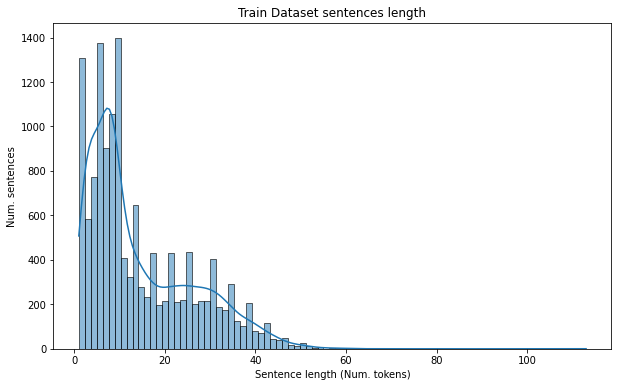

In [ ]:
# Training Data
plt.figure(figsize=(10, 6))
d = sns.histplot(data=train_sentences_lens, kde=True)
d.set_ylabel("Num. sentences")
d.set_xlabel("Sentence length (Num. tokens)")
_ = d.set_title("Train Dataset sentences length")\

print(f"Train Dataset sentences length distributions:")
print(pd.Series(train_sentences_lens).describe())

Test Dataset sentences length distributions:
count    3250.000000
mean       15.803692
std        12.603389
min         1.000000
25%         7.000000
50%        11.000000
75%        24.000000
max       109.000000
dtype: float64


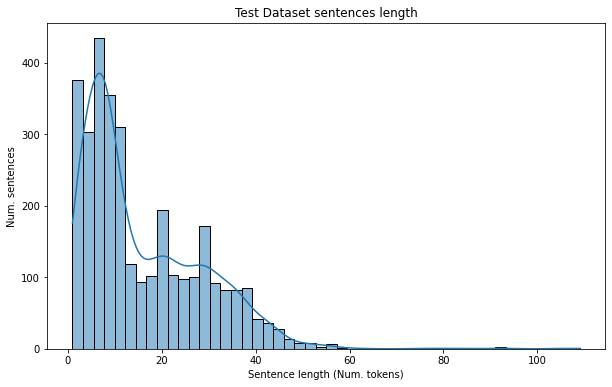

In [ ]:
# On validation data
plt.figure(figsize=(10, 6))
d = sns.histplot(data=test_sentences_lens, kde=True)
d.set_ylabel("Num. sentences")
d.set_xlabel("Sentence length (Num. tokens)")
_ = d.set_title("Test Dataset sentences length")\

print(f"Test Dataset sentences length distributions:")
print(pd.Series(test_sentences_lens).describe())

**Findings**


*   Validation dataset's sentences are a bit more longer than the sentences in the training data at mean value. However this point is not very critical, cause difference is not very high: 14.5 vs. 15.5


<h2>Tag Distribution: </h2>
Checking the Tag Distribution given the NER-tags in the dataset

In [ ]:
def ner_tags_distribution(text_data: List[TextData]) -> Dict[str, Any]:
    return Counter(list(itertools.chain.from_iterable([text.ner_tags for text in text_data]))).most_common()

def ner_tags_distribution_splitted(text_data: List[TextData]) -> Dict[str, Any]:
    tags_ = [split_tag(tag) for text in text_data for tag in text.ner_tags]
    return Counter([tag[0] if tag[1] is None else tag[1] for tag in tags_ ]).most_common()

In [ ]:
# Calculate separately

# Tags with prefixes: B- and I-
train_ner_tags_dist = pd.DataFrame.from_records(ner_tags_distribution(train_data), 
                                                columns=['tag', 'cnt'])
val_ner_tags_dist = pd.DataFrame.from_records(ner_tags_distribution(val_data), 
                                              columns=['tag', 'cnt'])
# Tags without prefixes
train_ner_tags_spl_dist = pd.DataFrame.from_records(ner_tags_distribution_splitted(train_data), 
                                                columns=['tag', 'cnt'])
val_ner_tags_spl_dist = pd.DataFrame.from_records(ner_tags_distribution_splitted(val_data), 
                                              columns=['tag', 'cnt'])

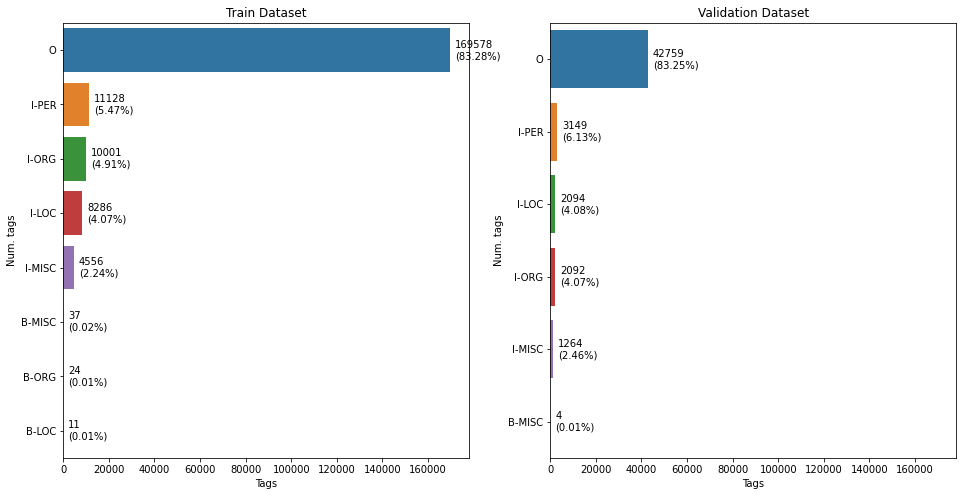

In [ ]:
# Visualize with prefixes
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 8))

axes[0].set_title('Train Dataset')
sns.barplot(data=train_ner_tags_dist, y="tag", x='cnt', ax=axes[0])
axes[0].set_ylabel("Num. tags")
axes[0].set_xlabel("Tags")

sum_train_tags = sum([p.get_width() for p in axes[0].patches])
for p in axes[0].patches:
    axes[0].annotate(f"{int(p.get_width())}\n({round(100*(p.get_width()/sum_train_tags), 2)}%)",
                     xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

axes[1].set_title('Validation Dataset')
sns.barplot(data=val_ner_tags_dist, y="tag", x='cnt', ax=axes[1])
axes[1].set_ylabel("Num. tags")
axes[1].set_xlabel("Tags")

sum_val_tags = sum([p.get_width() for p in axes[1].patches])
for p in axes[1].patches:
    axes[1].annotate(f"{int(p.get_width())}\n({round(100*(p.get_width()/sum_val_tags), 2)}%)", 
                     xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

plt.show()

In [ ]:
ner_tags_dist = train_ner_tags_spl_dist.merge(val_ner_tags_spl_dist, 
                                              how='outer', on='tag', 
                                              suffixes=['_train', '_val']).fillna(0)
ner_tags_dist['cnt'] = (ner_tags_dist['cnt_train'] + ner_tags_dist['cnt_val']).astype('int')
entities_types = ner_tags_dist['tag'].unique().tolist()
print(f"No-prefixes entities types: {entities_types}")

ner_tags_dist = train_ner_tags_dist.merge(val_ner_tags_dist, 
                                          how='outer', on='tag', 
                                          suffixes=['_train', '_val']).fillna(0)
ner_tags_dist['cnt'] = (ner_tags_dist['cnt_train'] + ner_tags_dist['cnt_val']).astype('int')
pref_entities_types = ner_tags_dist['tag'].unique().tolist()
print(f"With-prefixes entities types: {pref_entities_types}")

No-prefixes entities types: ['O', 'PER', 'ORG', 'LOC', 'MISC']
With-prefixes entities types: ['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']


**Findings**

*   There is **a strong imbalance of classes**, and it does not make sense to take into account the OUT label at all in quality estimation of the model.
*   Another option is to augment our training dataset with new samples for NE classes: ``` [`PER`, `ORG`, `LOC`, `MISK`] ```

#### Spans of Named Entities

Named Entities  in texts are usually represented as contiguous spans of tokens, so let's discover **lengths distribution** of them and **average number of spans** in each sentence.

Let's select them and print some examples of them: 

In [ ]:
n_examples = 5
entities_examples = dict.fromkeys([t for t in entities_types if t != "O"])

for ent_name in [t for t in entities_types if t != "O"]:
    n_found = 0
    found_spans = []
    for d in train_data:
        if ent_name in np.unique([tag.split("-")[-1] for tag in d.ner_tags]):
            span_tokens = []
            start_i = d.ner_tags.index(f"I-{ent_name}")  # for IOB1 tagging
            for i, tag in enumerate(d.ner_tags[start_i:]):
                if tag in ["O", "B"]:  # for IOB1 tagging
                    break
                span_tokens.append(d.tokens[start_i+i])
            found_spans.append(" ".join(span_tokens))
            n_found += 1
            if n_found > n_examples:
                break
    entities_examples[ent_name] = found_spans

for ent, exs in entities_examples.items():
    print(f"{ent}:")
    for e in exs:
        print(f"\t{e}")

PER:
	Peter Blackburn
	Werner Zwingmann
	Nikolaus van der Pas
	Franz Fischler
	Fischler
	Fischler
ORG:
	EU
	European Commission
	European Union
	Commission
	European Union
	EU
LOC:
	BRUSSELS
	Germany
	Britain
	France
	Europe
	Germany
MISC:
	German
	German
	EU-wide
	Spanish
	BSE
	British


In [ ]:
def select_spans_IOB1(text_data: List[TextData]) -> List[List[int]]:
    all_spans = []
    
    # iterate over the texts
    for d in text_data:
        spans = []
        cur_tag = None
        cur_start = None
        # iterate over the tags
        for tag_i, tag in enumerate(d.ner_tags):
            tag_pos = tag[0]  # tag `position`
            if tag_pos == 'B':
                # save previous span, if exists
                if cur_tag is not None:
                    spans.append([cur_tag, cur_start, tag_i - 1])
                cur_start = tag_i  # new tag starts
                cur_tag = tag[2:]  # tag `name`
            elif tag_pos == 'I':
                # new tag starts
                if cur_tag is None: 
                    cur_start = tag_i  # new tag starts
                    cur_tag = tag[2:]  # tag `name`
            elif tag_pos == 'O':
                # span finished, saving
                if cur_tag is not None:
                    spans.append([cur_tag, cur_start, tag_i - 1])
                    cur_tag = None
                    cur_start = None
        # save last span    
        if cur_tag is not None:
            spans.append([cur_tag, cur_start, tag_i + 1])

        # set to current sequence excluding tag type
        # d.set_spans([s[1:] for s in spans])
        all_spans.append(spans)

    return all_spans

def span_length(start_i: int, end_i: int) -> int:
    """ 
    Assumes inclusive span bondaries. 
    """
    return end_i - start_i + 1

In [ ]:
# Retrieve spans of NE from train and val datasets
train_spans = select_spans_IOB1(train_data)
val_spans = select_spans_IOB1(val_data)

print(f"Train data contains: {sum([len(s) for s in train_spans])} NE spans.")
print(f"Val data contains: {sum([len(s) for s in val_spans])} NE spans.")

Train data contains: 23326 NE spans.
Val data contains: 5902 NE spans.


In [ ]:
# Train spans
train_spans = pd.DataFrame.from_records(list(itertools.chain.from_iterable(train_spans)), 
                                        columns=['tag', 'start_i', 'end_i'])
train_spans['span_len'] = train_spans[['start_i', 'end_i']].apply(lambda x: span_length(x[0], x[1]), axis=1)

print("General span length distribution:")
print(train_spans['span_len'].describe())

print("\nBy Tags:")
train_spans.groupby(by='tag')['span_len'].describe()

General span length distribution:
count    23326.000000
mean         1.490225
std          0.739609
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: span_len, dtype: float64

By Tags:


,count,mean,std,min,25%,50%,75%,max
tag,,,,,,,,
LOC,7125.0,1.190737,0.480061,1.0,1.0,1.0,1.0,10.0
MISC,3398.0,1.439082,0.808202,1.0,1.0,1.0,2.0,7.0
ORG,6271.0,1.617605,0.942275,1.0,1.0,1.0,2.0,10.0
PER,6532.0,1.721219,0.584773,1.0,1.0,2.0,2.0,6.0


In [ ]:
val_spans = pd.DataFrame.from_records(list(itertools.chain.from_iterable(val_spans)), 
                                        columns=['tag', 'start_i', 'end_i'])
val_spans['span_len'] = val_spans[['start_i', 'end_i']].apply(lambda x: span_length(x[0], x[1]), axis=1)

print("General span length distribution:")
print(val_spans['span_len'].describe())

print("\nBy Tags:")
val_spans.groupby(by='tag')['span_len'].describe()

General span length distribution:
count    5902.000000
mean        1.482379
std         0.743915
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: span_len, dtype: float64

By Tags:


,count,mean,std,min,25%,50%,75%,max
tag,,,,,,,,
LOC,1832.0,1.170306,0.433990,1.0,1.0,1.0,1.0,5.0
MISC,916.0,1.466157,0.805684,1.0,1.0,1.0,2.0,5.0
ORG,1325.0,1.575849,1.018569,1.0,1.0,1.0,2.0,10.0
PER,1829.0,1.735375,0.594431,1.0,1.0,2.0,2.0,7.0


**Findings**

*   The longest Named Entities are (as quite expected) are referring to names and surnames - `PER` tag.
*   Anyway, entities are on average less than 2 tokens, which means that they are mostly simple and do not contain nested Named Entities.